In [279]:
import kagglehub
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
from sklearn.metrics import classification_report, f1_score
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, GlobalAveragePooling2D, Dense, 
                                    Dropout, Concatenate, Multiply, Resizing, 
                                    BatchNormalization, Attention, Flatten)
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.callbacks import (ReduceLROnPlateau, EarlyStopping, 
                                      ModelCheckpoint, TensorBoard)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.metrics import AUC
#from tensorflow_addons.metrics import F1Score
from tensorflow.keras.utils import Sequence
import albumentations as A


In [280]:
# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

In [281]:
# Download dataset
path = kagglehub.dataset_download("anonymac12i3/ambivision")
print("Path to dataset files:", path)
dataset_path = Path(path)

Path to dataset files: /kaggle/input/ambivision


In [282]:
# Define base directory and subfolders
base_dir = Path("/kaggle/input/ambivision/Ambivision/Neurips_collection")
subfolders = ["Direction", "No_Direction", "Only_eyes", "random_baseline"]

records = []

In [283]:
## Step 1: Data Loading with Enhanced Preprocessing
def clean_label(label):
    """Comprehensive label cleaning with species standardization"""
    label = label.lower().strip()
    replacements = {
        "righteye": "", "lefteye": "",
        "elpehant": "elephant", "cateye": "cat",
        "tigerrrighteye": "tiger", "tigerr": "tiger",
        "pidgeon": "pigeon", "roosters": "rooster",
        "dolphine": "dolphin", "girraffe": "giraffe"
    }
    for wrong, correct in replacements.items():
        label = label.replace(wrong, correct)
    return label.strip()

In [284]:
def load_and_validate_data(base_dir, subfolders):
    """Enhanced data loading with comprehensive validation"""
    records = []
    for folder in subfolders:
        data_dir = base_dir / folder
        txt_files = list(data_dir.glob("*.txt"))
        print(f"{folder}: Found {len(txt_files)} annotation files")

        for txt_file in txt_files:
            try:
                with open(txt_file, 'r') as f:
                    lines = [line.strip() for line in f.readlines() if line.strip()]
                
                if len(lines) < 12:
                    continue

                label1 = clean_label(lines[0])
                label2 = clean_label(lines[6])
                
                if not (label1 or label2):
                    continue
                    
                # Find corresponding image
                img_path = next((data_dir / f"{txt_file.stem}{ext}" for ext in ['.png', '.jpg', '.jpeg'] 
                               if (data_dir / f"{txt_file.stem}{ext}").exists()), None)
                
                if img_path:
                    with Image.open(img_path) as img:
                        width, height = img.size
                    
                    # Validate and normalize coordinates
                    coords = [
                        float(lines[1])/width, float(lines[2])/height,  # keypoint1
                        float(lines[7])/width, float(lines[8])/height,  # keypoint2
                        float(lines[4]), float(lines[5]),  # vector1
                        float(lines[10]), float(lines[11])  # vector2
                    ]
                    
                    if all(0 <= val <= 1 for val in coords[:4]):  # Only check normalized keypoints
                        records.append({
                            "image": str(img_path),
                            "label1": label1,
                            "label2": label2,
                            "keypoints": coords[:4],
                            "vectors": coords[4:]
                        })
                        
            except Exception as e:
                print(f"Error processing {txt_file}: {str(e)}")
    return pd.DataFrame(records)


In [285]:
# Load data
base_dir = Path("/kaggle/input/ambivision/Ambivision/Neurips_collection")
subfolders = ["Direction", "No_Direction", "Only_eyes", "random_baseline"]
df = load_and_validate_data(base_dir, subfolders)
print(f"Loaded {len(df)} valid records")

Direction: Found 203 annotation files
No_Direction: Found 203 annotation files
Only_eyes: Found 203 annotation files
random_baseline: Found 203 annotation files
Loaded 806 valid records


In [286]:
df.head()

,image,label1,label2,keypoints,vectors
0,/kaggle/input/ambivision/Ambivision/Neurips_co...,fox,rabbit,"[0.1505952380952381, 0.31399521531100477, 0.81...","[0.0, 0.0, 0.9986178293325096, -0.052558833122..."
1,/kaggle/input/ambivision/Ambivision/Neurips_co...,tiger,rhinoceros,"[0.7741545893719807, 0.4053892215568862, 0.583...","[0.44443372809678855, 0.8958117331950893, 0.96..."
2,/kaggle/input/ambivision/Ambivision/Neurips_co...,tiger,rabbit,"[0.1471291866028708, 0.1869772998805257, 0.369...","[-0.6459422414661738, 0.7633862853691146, -0.9..."
3,/kaggle/input/ambivision/Ambivision/Neurips_co...,snake,rabbit,"[0.21334214002642007, 0.22972972972972974, 0.8...","[-0.99714268802795, -0.07554111272939015, 0.95..."
4,/kaggle/input/ambivision/Ambivision/Neurips_co...,lion,pigeon,"[0.2938701923076923, 0.34036144578313254, 0.71...","[-1.0, 0.0, 0.7550331183926435, 0.655686655446..."


In [287]:
df.isna().sum()

image        0
label1       0
label2       0
keypoints    0
vectors      0
dtype: int64

In [288]:
print("\nUnique label1 values:", df['label1'].nunique())
print("Unique label2 values:", df['label2'].nunique())


Unique label1 values: 47
Unique label2 values: 50


In [289]:
def create_attention_mask(keypoints, size=(224, 224)):
    if isinstance(keypoints, str):
        keypoints = ast.literal_eval(keypoints)
    mask = np.zeros((size[0], size[1]), dtype=np.float32)
    for i in range(0, len(keypoints), 2):
        x = int(keypoints[i] * size[1])
        y = int(keypoints[i + 1] * size[0])
        for dx in range(-15, 16):
            for dy in range(-15, 16):
                px, py = x + dx, y + dy
                if 0 <= px < size[1] and 0 <= py < size[0]:
                    dist = np.sqrt(dx**2 + dy**2)
                    mask[py, px] += np.exp(-dist**2 / (2 * 8**2))
    mask = np.clip(mask, 0, 1)
    return np.repeat(mask[..., np.newaxis], 3, axis=-1)



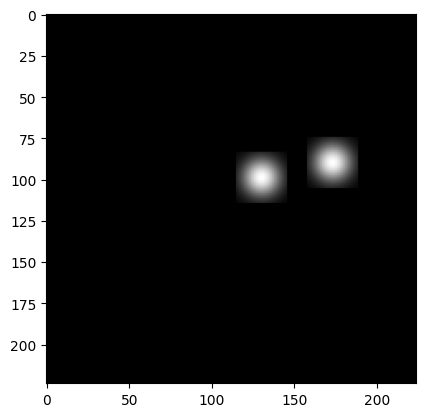

In [290]:
# Usage
sample = df.iloc[1]
mask = create_attention_mask(sample['keypoints'])
plt.imshow(mask.squeeze(), cmap='jet')

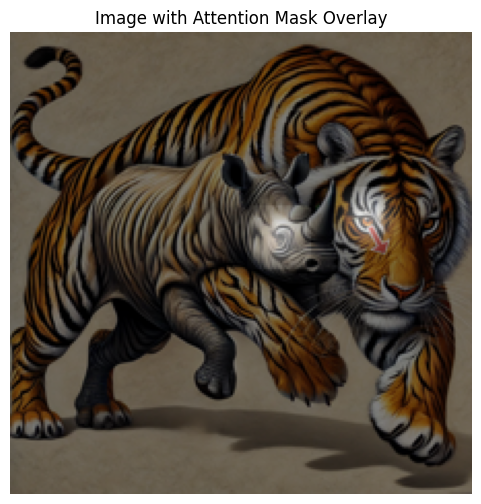

In [291]:
sample = df.iloc[1]
img = np.array(Image.open(sample['image']).resize((224, 224))) / 255.0  # Normalize

mask = create_attention_mask(sample['keypoints'])  # (224,224,1)

plt.figure(figsize=(6, 6))

# Show image
plt.imshow(img)

# Overlay mask with transparency
plt.imshow(mask.squeeze(), cmap='jet', alpha=0.5)  # alpha controls transparency
plt.axis('off')
plt.title("Image with Attention Mask Overlay")
plt.show()


In [292]:
df = df.dropna(subset=['label1', 'label2'])
labels = df[['label1', 'label2']].values
mlb = MultiLabelBinarizer()
encoded_labels = mlb.fit_transform(labels)
print("Classes:", mlb.classes_)

Classes: ['badger' 'bear' 'bee' 'bird' 'bison' 'butterfly' 'cat' 'chameleon'
 'cheetah' 'crab' 'crane' 'crocodile' 'deer' 'dog' 'dolphin' 'donkey'
 'dragonfly' 'duck' 'eagle' 'elephant' 'falcon' 'fish' 'flamingo' 'fox'
 'frog' 'giraffe' 'gorilla' 'hawk' 'hedgehog' 'heron' 'horse'
 'hummingbird' 'jaguar' 'kangaroo' 'leopard' 'lion' 'monkey' 'moth'
 'mouse' 'octopus' 'otter' 'owl' 'panda' 'panther' 'parrot' 'peacock'
 'pelican' 'penguin' 'pigeon' 'rabbit' 'raven' 'rhinoceros' 'rooster'
 'seagull' 'shark' 'snake' 'sparrow' 'spider' 'squirrel' 'stag' 'swan'
 'tiger' 'toucan' 'turtle' 'whale' 'wolf' 'zebra']


In [293]:
print(f"Total classes: {len(mlb.classes_)}")

Total classes: 67


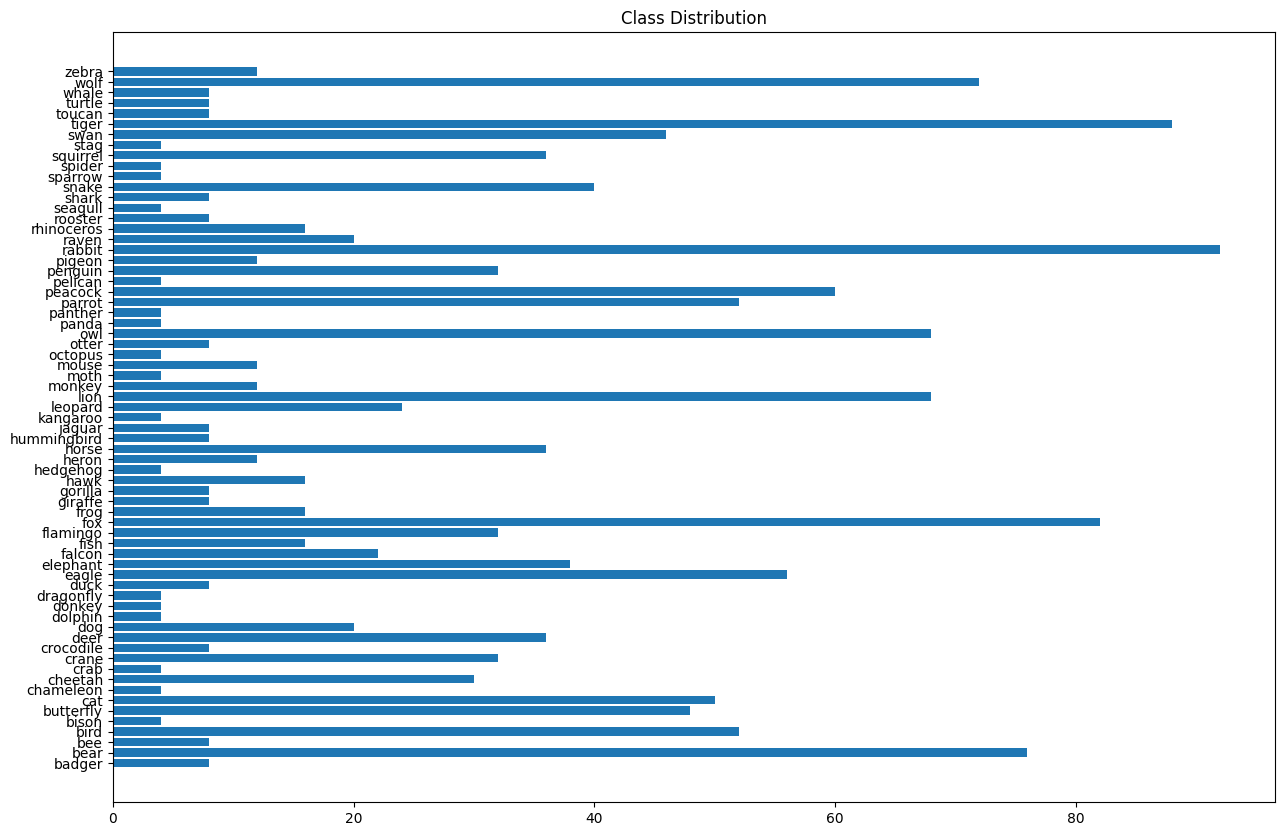

In [294]:
# Analyze and handle class imbalance
class_counts = encoded_labels.sum(axis=0)
plt.figure(figsize=(15, 10))
plt.barh(mlb.classes_, class_counts)
plt.title("Class Distribution")
plt.show()

In [295]:
# Split
train_df, temp_df, y_train, y_temp = train_test_split(df, encoded_labels, test_size=0.3, random_state=42)
val_df, test_df, y_val, y_test = train_test_split(temp_df, y_temp, test_size=1/3, random_state=42)


In [296]:
import ast

# Prepare combined keypoints + vectors for scaler
train_features = []
for _, row in train_df.iterrows():
    kp = row['keypoints']
    vec = row['vectors']

    # Convert from string to list if needed
    if isinstance(kp, str):
        kp = ast.literal_eval(kp)
    if isinstance(vec, str):
        vec = ast.literal_eval(vec)

    train_features.append(kp + vec)  # 8 features total

# Fit scaler on 8D combined features
scaler = StandardScaler()
scaler.fit(train_features)


StandardScaler()

In [297]:
from tensorflow.keras.utils import Sequence
from PIL import Image
import numpy as np
import albumentations as A

# Augmentation pipeline
augmentations = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=20, p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.GaussianBlur(p=0.1),
    A.CoarseDropout(max_holes=8, max_height=20, max_width=20,
                    min_height=10, min_width=10, p=0.2)
])

from tensorflow.keras.utils import Sequence
import numpy as np
from PIL import Image

class DataGenerator(Sequence):
    def __init__(self, df, labels, batch_size=16, shuffle=True):
        self.df = df.reset_index(drop=True)
        self.labels = labels
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indices = np.arange(len(df))
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.df) / self.batch_size))

    def __getitem__(self, index):
        indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        batch_df = self.df.iloc[indices]

        X_img, X_masks, X_features = [], [], []

        for _, row in batch_df.iterrows():
            # --- Load and normalize image ---
            img = Image.open(row['image']).convert('RGB')  # force 3 channels
            img = img.resize((224, 224))
            img = np.array(img) / 255.0  # normalize to [0,1]

            # Apply augmentations if defined
            if 'augmentations' in globals() and augmentations is not None:
                aug_res = augmentations(image=img)
                img = aug_res['image']

            # --- Keypoints and vectors ---
            kp = row['keypoints']
            vec = row['vectors']

            # Convert from string to list if needed
            if isinstance(kp, str):
                kp = ast.literal_eval(kp)
            if isinstance(vec, str):
                vec = ast.literal_eval(vec)

            # Combine (4 keypoints + 4 vectors = 8 features)
            features = kp + vec
            features = scaler.transform([features])[0]  # scale 8D feature

            # --- Create attention mask from keypoints ---
            mask = create_attention_mask(kp)  # returns (224,224,3)

            # Append
            X_img.append(img)
            X_masks.append(mask)
            X_features.append(features)

        # Convert to numpy arrays
        X_img = np.array(X_img, dtype=np.float32)
        X_masks = np.array(X_masks, dtype=np.float32)
        X_features = np.array(X_features, dtype=np.float32)
        y_batch = np.array(self.labels[indices], dtype=np.float32)

        return {
            "image_input": X_img,       # matches model input name
            "mask_input": X_masks,
            "vector_input": X_features
        }, y_batch

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)




/tmp/ipykernel_36/3514963834.py:12: UserWarning: Argument(s) 'max_holes, max_height, max_width, min_height, min_width' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=8, max_height=20, max_width=20,


In [298]:
{
  "image_input": (32, 224, 224, 3),
  "mask_input":  (32, 224, 224, 3),   # ✅ should now be correct
  "feature_input": (32, 8)
}, (32, 67)


({'image_input': (32, 224, 224, 3),
  'mask_input': (32, 224, 224, 3),
  'feature_input': (32, 8)},
 (32, 67))

In [299]:
train_gen = DataGenerator(train_df, y_train)
val_gen = DataGenerator(val_df, y_val, shuffle=False)

In [300]:
def build_advanced_model(num_classes):
    img_input = Input(shape=(224, 224, 3), name='image_input')
    mask_input = Input(shape=(224, 224, 3), name='mask_input')
    vector_input = Input(shape=(8,), name='vector_input')

    base_model = EfficientNetB4(weights='imagenet', include_top=False, input_tensor=img_input)
    for layer in base_model.layers[-20:]:
        layer.trainable = True

    x = base_model.output
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = GlobalAveragePooling2D()(x)

    x = Concatenate()([x, vector_input])
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.3)(x)
    output = Dense(num_classes, activation='sigmoid')(x)

    model = Model(inputs=[img_input, mask_input, vector_input], outputs=output)
    model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy', AUC(name='auc')])
    return model


In [301]:
model = build_advanced_model(len(mlb.classes_))
model.summary()

Model: "functional_21"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_42        │ (None, 224, 224,  │          0 │ image_input[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_21    │ (None, 224, 224,  │          7 │ rescaling_42[0][… │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_43        │ (None, 224, 224,  │          0 │ normalization_21… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_43[0][… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │      1,296 │ stem_conv_pad[0]… │
│                     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        192 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        432 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        192 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 48)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 48)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 12)  │        588 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 48)  │        624 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 48)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │      1,152 │ block1a_se_excit

 Total params: 21,973,922 (83.82 MB)

 Trainable params: 21,848,203 (83.34 MB)

 Non-trainable params: 125,719 (491.09 KB)

In [302]:
callbacks = [
    EarlyStopping(monitor='val_auc', patience=10, restore_best_weights=True, mode='max'),
    ReduceLROnPlateau(monitor='val_auc', factor=0.5, patience=5, mode='max'),
    ModelCheckpoint('best_model.keras', monitor='val_auc', save_best_only=True, mode='max')
]


In [303]:
history = model.fit(train_gen, validation_data=val_gen, epochs=50, callbacks=callbacks)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


I0000 00:00:1753599691.111682     143 service.cc:148] XLA service 0x77fc0c004a30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753599691.114277     143 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1753599691.114309     143 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1753599702.299357     143 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1753599719.056343     143 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1753599719.190815     143 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1753599719.518672     143 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. Th

10/36 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.0106 - auc: 0.5094 - loss: 0.7003

E0000 00:00:1753599799.772650     144 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1753599799.906920     144 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1753599800.131772     144 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1753599800.269941     144 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.0189 - auc: 0.5590 - loss: 0.6672

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


36/36 ━━━━━━━━━━━━━━━━━━━━ 341s 4s/step - accuracy: 0.0191 - auc: 0.5598 - loss: 0.6657 - val_accuracy: 0.0248 - val_auc: 0.5348 - val_loss: 0.4361 - learning_rate: 1.0000e-04
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 65s 2s/step - accuracy: 0.0301 - auc: 0.5888 - loss: 0.3687 - val_accuracy: 0.0311 - val_auc: 0.6064 - val_loss: 0.1682 - learning_rate: 1.0000e-04
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 64s 2s/step - accuracy: 0.0488 - auc: 0.6133 - loss: 0.1664 - val_accuracy: 0.0435 - val_auc: 0.7006 - val_loss: 0.1357 - learning_rate: 1.0000e-04
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 65s 2s/step - accuracy: 0.0858 - auc: 0.6943 - loss: 0.1345 - val_accuracy: 0.0435 - val_auc: 0.7243 - val_loss: 0.1302 - learning_rate: 1.0000e-04
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 65s 2s/step - accuracy: 0.0798 - auc: 0.7211 - loss: 0.1293 - val_accuracy: 0.0435 - val_auc: 0.7347 - val_loss: 0.1254 - learning_rate: 1.0000e-04
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 64s 2s/step - accuracy: 0.0766 - auc: 0.75

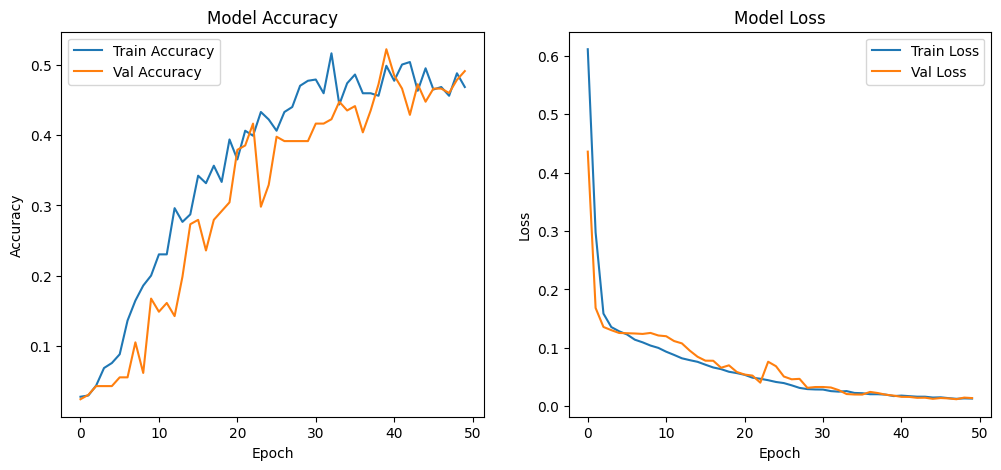

In [304]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [305]:
# Load best model
best_model = tf.keras.models.load_model('best_model.h5')

# Evaluate on test data
test_loss, test_acc, test_auc = best_model.evaluate(test_gen)
print(f"Test Accuracy: {test_acc:.4f}, Test AUC: {test_auc:.4f}")


FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'best_model.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [306]:
import os

if os.path.exists("best_model.h5"):
    best_model = tf.keras.models.load_model("best_model.h5", compile=False)
    print("Best model loaded successfully!")
else:
    print("No best_model.h5 found — check if ModelCheckpoint saved the file.")


No best_model.h5 found — check if ModelCheckpoint saved the file.


In [308]:
# Load the best saved model
best_model = tf.keras.models.load_model('best_model.keras')


In [311]:
from sklearn.metrics import classification_report

# Get predictions
predictions = best_model.predict(val_gen)
predicted_labels = (predictions > 0.5).astype(int)

# True labels
true_labels = encoded_labels[test_df.index]

# Classification report
print(classification_report(true_labels, predicted_labels, target_names=mlb.classes_, zero_division=0))


11/11 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step


ValueError: Found input variables with inconsistent numbers of samples: [81, 161]

In [314]:
# 1. Get predictions from best_model
predictions = best_model.predict(val_gen)
predicted_labels = (predictions > 0.5).astype(int)

# 2. True labels directly from generator
true_labels = val_gen.labels  # Already aligned with generator output

# 3. Classification report
from sklearn.metrics import classification_report
print(classification_report(true_labels, predicted_labels,
                            target_names=mlb.classes_,
                            zero_division=0))


11/11 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step
              precision    recall  f1-score   support

      badger       1.00      1.00      1.00         1
        bear       1.00      1.00      1.00         9
         bee       0.00      0.00      0.00         1
        bird       1.00      1.00      1.00         5
       bison       0.00      0.00      0.00         0
   butterfly       1.00      0.57      0.73        14
         cat       1.00      1.00      1.00        10
   chameleon       1.00      1.00      1.00         1
     cheetah       1.00      1.00      1.00         5
        crab       0.00      0.00      0.00         0
       crane       1.00      0.73      0.84        11
   crocodile       1.00      1.00      1.00         2
        deer       1.00      1.00      1.00         7
         dog       1.00      0.33      0.50         6
     dolphin       0.00      0.00      0.00         0
      donkey       0.00      0.00      0.00         3
   dragonfly       0.00      0.00      0.0